1. Dataset contains Monthly and Daily prices of Natural gas, starting from January 1997 to current year. Prices are in nominal dollars. The task is to predict the price of natural gas using RNN model for the dataset
https://datahub.io/core/natural-gas#resource-daily or

https://www.kaggle.com/datasets/joebeachcapital/natural-gas-prices Given the price of last ten 10 days, corresponds to sequence_length, the RNN model must predict the price for the 11th day.

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('daily.csv')
df.head()

,Date,Price
0,1997-01-07,3.82
1,1997-01-08,3.80
2,1997-01-09,3.61
3,1997-01-10,3.92
4,1997-01-13,4.00


In [3]:
df.isna().value_counts()

Date   Price
False  False    5479
       True        1
Name: count, dtype: int64

In [4]:
df.dropna(inplace=True)
df.isna().value_counts()

Date   Price
False  False    5479
Name: count, dtype: int64

In [5]:
y = df['Price'].values
x = np.arange(1,len(y),1)
print(x)
print(y)
len(y)

[   1    2    3 ... 5476 5477 5478]
[3.82 3.8  3.61 ... 3.16 3.19 3.26]


5479

In [6]:
scaler = MinMaxScaler()
y = scaler.fit_transform(y.reshape(-1,1))
y = y.flatten()
y.shape

(5479,)

In [7]:
Sequence_Length = 10
X = []
Y = []

for i in range(0, len(y) - Sequence_Length):
    list1 = []
    for j in range(i, i + Sequence_Length):
        list1.append(y[j])
    X.append(list1)
    Y.append(y[i + Sequence_Length])

In [8]:
print(X)
print(Y)

[[0.1589213998852553, 0.15777395295467583, 0.14687320711417096, 0.1646586345381526, 0.16924842226047046, 0.16982214572576018, 0.18875502008032127, 0.2099827882960413, 0.16408491107286288, 0.1267928858290304], [0.15777395295467583, 0.14687320711417096, 0.1646586345381526, 0.16924842226047046, 0.16982214572576018, 0.18875502008032127, 0.2099827882960413, 0.16408491107286288, 0.1267928858290304, 0.11130235226620772], [0.14687320711417096, 0.1646586345381526, 0.16924842226047046, 0.16982214572576018, 0.18875502008032127, 0.2099827882960413, 0.16408491107286288, 0.1267928858290304, 0.11130235226620772, 0.11474469305794607], [0.1646586345381526, 0.16924842226047046, 0.16982214572576018, 0.18875502008032127, 0.2099827882960413, 0.16408491107286288, 0.1267928858290304, 0.11130235226620772, 0.11474469305794607, 0.1095811818703385], [0.16924842226047046, 0.16982214572576018, 0.18875502008032127, 0.2099827882960413, 0.16408491107286288, 0.1267928858290304, 0.11130235226620772, 0.11474469305794607

In [9]:
X = np.array(X)
Y = np.array(Y)

In [10]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.10,random_state=42,shuffle=False,stratify=None)

In [11]:
class NGTTimeSeries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]

    def __len__(self):
        return len(self.x)

In [12]:
dataset = NGTTimeSeries(X_train,Y_train)
train_loader = DataLoader(dataset,batch_size=256,shuffle=True)

In [13]:
class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=1,hidden_size=5,num_layers=1,batch_first=True)
        self.fc1 = nn.Linear(in_features=5,out_features=1)

    def forward(self,x):
        output,status = self.rnn(x)
        output = output[:,-1,:]
        output = self.fc1(torch.relu(output))
        return output

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [15]:
torch.manual_seed(42)
model = RNNModel().to(device)
model

RNNModel(
  (rnn): RNN(1, 5, batch_first=True)
  (fc1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
epochs = 1500

In [17]:
# Training loop
for i in range(epochs):
    for j, data in enumerate(train_loader):
        inputs, targets = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        y_pred = model(inputs.view(-1, Sequence_Length, 1)).reshape(-1)

        loss = criterion(y_pred, targets)

        loss.backward()

        optimizer.step()

    if i % 50 == 0:
        print(f"Epoch {i}: Loss:{loss}")


Epoch 0: Loss:0.03783135116100311
Epoch 50: Loss:0.005258101038634777
Epoch 100: Loss:0.006517678499221802
Epoch 150: Loss:0.0005320117925293744
Epoch 200: Loss:0.0006217508926056325
Epoch 250: Loss:0.00021949630172457546
Epoch 300: Loss:0.00019314410747028887
Epoch 350: Loss:0.00021706642291974276
Epoch 400: Loss:0.0001722528540994972
Epoch 450: Loss:0.00026466086274012923
Epoch 500: Loss:0.00019715039525181055
Epoch 550: Loss:0.0009437613189220428
Epoch 600: Loss:0.0002525712188798934
Epoch 650: Loss:0.0001631650811759755
Epoch 700: Loss:0.00014249257219489664
Epoch 750: Loss:0.0003847715852316469
Epoch 800: Loss:0.0003033209650311619
Epoch 850: Loss:0.0002609536168165505
Epoch 900: Loss:0.00034041592152789235
Epoch 950: Loss:0.0003474646946415305
Epoch 1000: Loss:9.356044029118493e-05
Epoch 1050: Loss:0.00030390045139938593
Epoch 1100: Loss:0.00011010879097739235
Epoch 1150: Loss:0.00026887256535701454
Epoch 1200: Loss:0.00010153189941775054
Epoch 1250: Loss:0.00011892205657204613
E

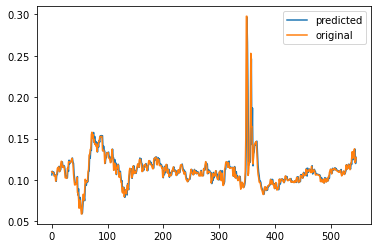

In [18]:
test_set = NGTTimeSeries(X_test,Y_test)
test_inputs = test_set[:][0].to(device)

with torch.no_grad():
    test_pred = model(test_inputs.view(-1, 10, 1)).view(-1).cpu()

plt.plot(test_pred.numpy(), label='predicted')
plt.plot(test_set[:][1].view(-1), label='original')
plt.legend()
plt.show()


2. The data provided at the link https://download.pytorch.org/tutorial/data.zip consists of names stored in the format {language: [names ...]} i.e. each language contains a list of names. Train a RNN on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling.

5000 5% 2.9318
10000 10% 3.0733
15000 15% 3.3949
20000 20% 2.3992
25000 25% 3.2359
30000 30% 2.0576
35000 35% 2.2470
40000 40% 2.3042
45000 45% 2.7480
50000 50% 1.9176
55000 55% 2.4305
60000 60% 2.1228
65000 65% 1.7864
70000 70% 2.0313
75000 75% 2.4306
80000 80% 2.0862
85000 85% 2.5077
90000 90% 1.8637
95000 95% 2.3207
100000 100% 2.0455


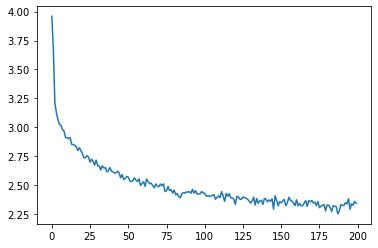

In [37]:
import torch
import torch.nn as nn
import random
import string
import unicodedata
import glob
import os
from io import open

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters) + 1  # Plus EOS marker

def findFiles(path): 
    return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn' and c in all_letters)

def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)  # EOS
    return torch.LongTensor(letter_indexes)

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category).to(device)
    input_line_tensor = inputTensor(line).to(device)
    target_line_tensor = targetTensor(line).to(device)
    return category_tensor, input_line_tensor, target_line_tensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn = RNN(n_letters, 128, n_letters).to(device)

criterion = nn.NLLLoss()
learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()
    loss = torch.Tensor([0]).to(device)

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%d %d%% %.4f' % (iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0


import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)
plt.show()


3. Implement a next character predictor using RNN Model

In [58]:
import torch 
from torch import nn 
import numpy as np 

In [59]:
text = ['hey how are you','good i am fine','have a nice day']
chars = set(''.join(text))
print(chars)
int2char = dict(enumerate(chars))
print(int2char)
char2int = {char: idx for idx,char in int2char.items()}
print(char2int)


{'o', 'i', 'a', 'g', 'f', 'u', 'm', 'h', 'r', 'n', 'e', ' ', 'c', 'd', 'v', 'y', 'w'}
{0: 'o', 1: 'i', 2: 'a', 3: 'g', 4: 'f', 5: 'u', 6: 'm', 7: 'h', 8: 'r', 9: 'n', 10: 'e', 11: ' ', 12: 'c', 13: 'd', 14: 'v', 15: 'y', 16: 'w'}
{'o': 0, 'i': 1, 'a': 2, 'g': 3, 'f': 4, 'u': 5, 'm': 6, 'h': 7, 'r': 8, 'n': 9, 'e': 10, ' ': 11, 'c': 12, 'd': 13, 'v': 14, 'y': 15, 'w': 16}


In [60]:
max_len = len(max(text,key=len))
print(f"longest string has {max_len} characters")

longest string has 15 characters


In [61]:
#padding 
for i in range(len(text)):
    while len(text[i]) < max_len:
        text[i] += ' '
text

['hey how are you', 'good i am fine ', 'have a nice day']

In [62]:
input_seq = []
target_seq = []
for i in range(len(text)):
    input_seq.append(text[i][:-1])
    target_seq.append(text[i][1:])
    print(f"Input sequence: {input_seq}\ntarget sequence: {target_seq}")


Input sequence: ['hey how are yo']
target sequence: ['ey how are you']
Input sequence: ['hey how are yo', 'good i am fine']
target sequence: ['ey how are you', 'ood i am fine ']
Input sequence: ['hey how are yo', 'good i am fine', 'have a nice da']
target sequence: ['ey how are you', 'ood i am fine ', 'ave a nice day']


In [63]:
for i in range(len(text)):
    input_seq[i] = [char2int[character] for character in input_seq[i]]
    target_seq[i] = [char2int[character] for character in target_seq[i]]
print(input_seq)
print(target_seq)

[[7, 10, 15, 11, 7, 0, 16, 11, 2, 8, 10, 11, 15, 0], [3, 0, 0, 13, 11, 1, 11, 2, 6, 11, 4, 1, 9, 10], [7, 2, 14, 10, 11, 2, 11, 9, 1, 12, 10, 11, 13, 2]]
[[10, 15, 11, 7, 0, 16, 11, 2, 8, 10, 11, 15, 0, 5], [0, 0, 13, 11, 1, 11, 2, 6, 11, 4, 1, 9, 10, 11], [2, 14, 10, 11, 2, 11, 9, 1, 12, 10, 11, 13, 2, 15]]


In [64]:
dict_size =  len(char2int)
seq_len = max_len - 1
batch_size = len(text)

In [65]:
from torch.nn.functional import one_hot
input_seq = one_hot(torch.tensor(input_seq),num_classes=dict_size)
target_seq = one_hot(torch.tensor(target_seq),num_classes=dict_size)

In [67]:
input_seq,target_seq

(tensor([[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 
         [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [68]:
print("Input sequence one-hot shape:", input_seq.shape)
print("Target sequence one-hot shape:", target_seq.shape)

Input sequence one-hot shape: torch.Size([3, 14, 17])
Target sequence one-hot shape: torch.Size([3, 14, 17])


In [69]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [70]:
class RNNModel(nn.Module):
    def __init__(self, input_size,output_size,hidden_dim,n_layers) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size,hidden_dim,n_layers,batch_first=True)
        self.fc = nn.Linear(hidden_dim,output_size)
    
    def forward(self,x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        output,hidden = self.rnn(x,hidden)
        output = output.contiguous().view(-1,self.hidden_dim)
        output = self.fc(output)
        return output,hidden
    
    def init_hidden(self,batch_size):
        hidden = torch.zeros(self.n_layers,batch_size,self.hidden_dim).to(device)
        return hidden

torch.manual_seed(42)
model = RNNModel(input_size=dict_size,output_size=dict_size,hidden_dim=12,n_layers=1).to(device)
model

RNNModel(
  (rnn): RNN(17, 12, batch_first=True)
  (fc): Linear(in_features=12, out_features=17, bias=True)
)

In [71]:
n_epochs = 100
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [72]:
torch.manual_seed(42)
input_seq = input_seq.to(device).float()
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    output, hidden = model(input_seq)
    output = output.to(device)
    target_seq_one_hot = target_seq.to(device).float()
    loss = criterion(output, target_seq_one_hot.view(-1, target_seq_one_hot.size(-1)))
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}/{n_epochs} Loss: {loss.item()} ")


Epoch: 10/100 Loss: 2.449730396270752 
Epoch: 20/100 Loss: 2.1862666606903076 
Epoch: 30/100 Loss: 1.852140188217163 
Epoch: 40/100 Loss: 1.412236213684082 
Epoch: 50/100 Loss: 0.9973600506782532 
Epoch: 60/100 Loss: 0.6887011528015137 
Epoch: 70/100 Loss: 0.4799884557723999 
Epoch: 80/100 Loss: 0.34057506918907166 
Epoch: 90/100 Loss: 0.24987104535102844 
Epoch: 100/100 Loss: 0.1908598691225052 


In [73]:
def predict(model, character):
    character = torch.tensor([[char2int[c] for c in character]])
    character = one_hot(character, num_classes=dict_size).float().to(device)
    output, hidden = model(character)
    output = output.to(device)
    hidden = hidden.to(device)
    prob = torch.softmax(output[-1], dim=0).data
    char_ind = torch.max(prob, dim=0)[1].item()
    return int2char[char_ind], hidden

In [74]:
test_character = 'h'
predicted_character, _ = predict(model, test_character)
print(f"The predicted character for '{test_character}' is '{predicted_character}'")

The predicted character for 'h' is 'a'


In [75]:
def sample(model,out_len,start='hi'):
    model.eval()
    start = start.lower()
    chars = [ch for ch in start]
    size = out_len - len(chars)
    for i in range(size):
        char, h = predict(model,chars)
        chars.append(char)
    return ''.join(chars)

In [76]:
sample(model,15,'good')

'good i am fine '